## Multiprocessing examples

In this example we will analyze several cases were we can use multiprocessing for accelerating our computations. Some of this cases are implemented in the modules. Other cases are implemented in specific functions.

The cases that we will se include:

* Rayleigh-Sommerfed computations in XZ and XYZ modules.
* Polychromatic light
* Extended sources
* Polychromatic and extended sources
* Simultaneous simulations, as moving parts


In [1]:
%matplotlib inline

In [2]:
import time

from diffractio import degrees, mm, np, num_max_processors, plt, um
from diffractio.scalar_fields_X import (Scalar_field_X,
                                        extended_polychromatic_source,
                                        extended_source_multiprocessing,
                                        polychromatic_multiprocessing)
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.utils_multiprocessing import (_pickle_method, _unpickle_method,
                                              execute_multiprocessing)
from multiprocessing import Pool
from diffractio.utils_optics import (gauss_spectrum, lorentz_spectrum,
                                     uniform_spectrum)

from diffractio.scalar_fields_XZ import Scalar_field_XZ


In [3]:
from matplotlib import rcParams

rcParams['figure.figsize']=(6,4)
rcParams['figure.dpi']=125

### Extended Source

num_proc: 1, time=1.5737345218658447


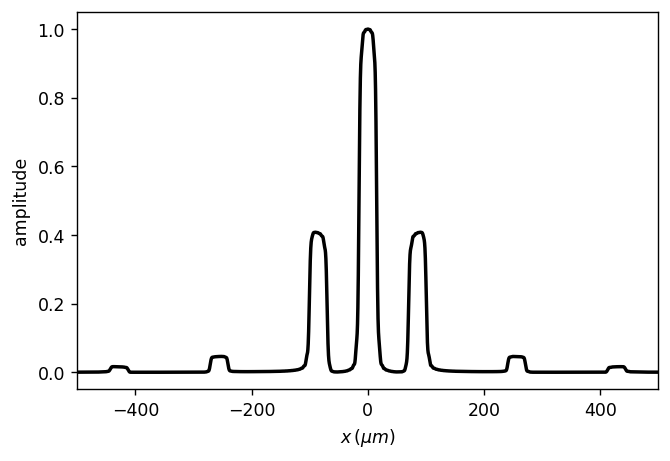

In [4]:
x = np.linspace(-500 * um, 500 * um, 1024*8)
wavelength = 0.850 * um
num_fuentes = 101
S = 3000 * um
z0 = -500 * mm
period = 50 * um
focal = 5 * mm

red = Scalar_mask_X(x, wavelength)
red.ronchi_grating(x0=0 * um, period=period, fill_factor=0.5)

lens = Scalar_mask_X(x, wavelength)
lens.lens(x0=0, focal=focal, radius=30 * mm)

u1 = Scalar_source_X(x, wavelength)

# posiciones de la fuente
x0s = np.linspace(-S / 2, S / 2, num_fuentes)
intensities = Scalar_field_X(x, wavelength)

time1 = time.time()
for x0 in x0s:
    u1.spherical_wave(
        A=1,
        x0=x0,
        z0=z0,
        radius=100000 * um,
        mask=False,
        normalize=True)
    u2 = u1 * lens * red
    u2.RS(z=focal, new_field=False, verbose=False)
    intensities.u = intensities.u + abs(u2.u)**2

intensities.u = intensities.u / intensities.u.max()
time_proc = time.time() - time1
print("num_proc: {}, time={}".format(1, time_proc))
intensities.draw(kind='amplitude')

In [5]:
def __experiment_extended_source__(x0):

    x = np.linspace(-500 * um, 500 * um, 1024)
    wavelength = 0.850 * um
    z0 = -500 * mm
    period = 50 * um
    focal = 5 * mm

    red = Scalar_mask_X(x, wavelength)
    red.ronchi_grating(x0=0 * um, period=period, fill_factor=0.5)

    lens = Scalar_mask_X(x, wavelength)
    lens.lens(x0=0, focal=focal, radius=30 * mm)

    u1 = Scalar_source_X(x, wavelength)

    u1.spherical_wave(
        A=1., x0=x0, z0=z0, radius=100000 * um, mask=False, normalize=True)
    u2 = u1 * red * lens
    u2.RS(z=focal, new_field=False, verbose=False)

    return u2

In [6]:
x0s = np.linspace(-1500 * um, 1500 * um, 101)
x0_central = 0 * um

intensity0, u_s0, time_proc0 = extended_source_multiprocessing(
    __experiment_extended_source__,
    x0_central,
    num_processors=1,
    verbose=True)

intensity, u_s, time_proc = extended_source_multiprocessing(
    __experiment_extended_source__,
    x0s,
    num_processors=num_max_processors,
    verbose=True)


num_proc: 1, time=0.004604816436767578
num_proc: 8, time=0.19691920280456543


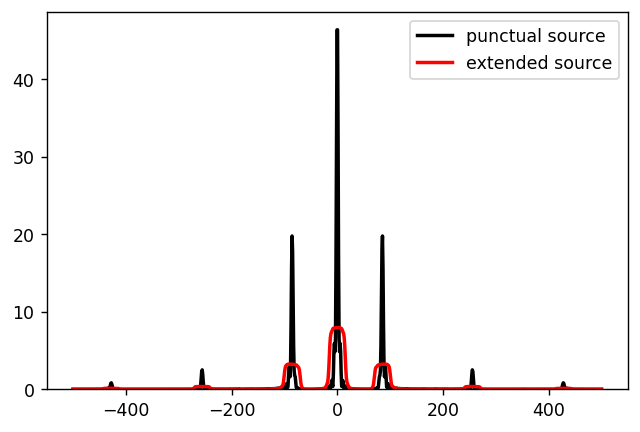

In [7]:
plt.figure()
plt.plot(u_s0.x, intensity0, 'k', lw=2, label='punctual source')
plt.plot(u_s[0].x, intensity, 'r', lw=2, label='extended source')
plt.legend()
plt.ylim(bottom=0);

### Polychromatic light sources

In [8]:
wavelengths = np.linspace(.3 * um, .9 * um, 1001)

w_central = wavelengths.mean()

spectrum_gauss = gauss_spectrum(
    wavelengths=wavelengths,
    w_central=w_central,
    Dw=0.4,
    normalize=True)


In [9]:
def __function_polychromatic__(wavelength):
    x0 = np.linspace(-75 * um, 75 * um, 1024 * 8)

    t1 = Scalar_mask_X(x0, wavelength)
    t1.slit(x0=0, size=100 * um)

    f1 = Scalar_source_X(x0, wavelength)
    f1.gauss_beam(x0=0 * um, w0=200 * um, z0=0 * um, A=1, theta=0. * degrees)

    u1 = f1 * t1
    u1.RS(z=10 * um, new_field=False, verbose=False)

    return u1

In [10]:
time1=time.time()
intensity_0, u_s0, time_monochromatic_proc_0 = polychromatic_multiprocessing(
    __function_polychromatic__,
    w_central,
    1,
    num_processors=1,
    verbose=True)
time_proc_0 = time.time() - time1
print("Monochromatic: time={:2.5f}".format(time_proc_0))

Monochromatic: time=0.02545


In [11]:
time1=time.time()
intensity_1, u_s1, time_proc_1 = polychromatic_multiprocessing(
    __function_polychromatic__,
    wavelengths,
    spectrum_gauss,
    num_processors=1,
    verbose=True)
time_proc1 = time.time() - time1

print("Polychromatic - num_proc: 1,  time={}".format(time_proc_1))

num_proc: 1, time=14.597208738327026
1001
Polychromatic - num_proc: 1,  time=14.597208738327026


In [12]:
intensity_n, u_s, time_proc_n = polychromatic_multiprocessing(
    __function_polychromatic__,
    wavelengths,
    spectrum_gauss,
    num_processors=num_max_processors,
    verbose=True)

num_proc: 8, time=3.9000954627990723
1001


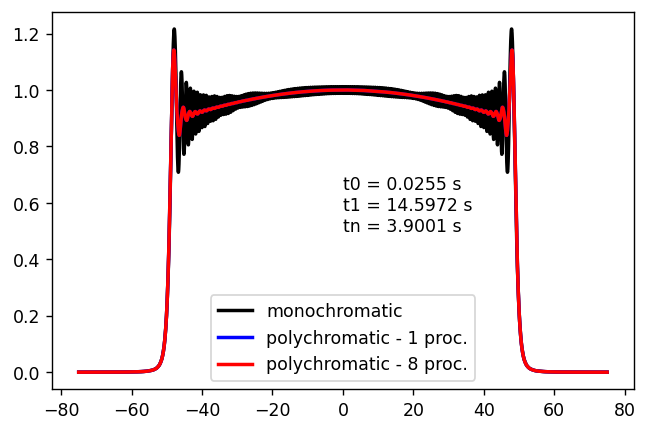

In [13]:
plt.figure()
plt.plot(u_s0.x, intensity_0, 'k', lw=2, label='monochromatic')
plt.plot(u_s0.x, intensity_1, 'b', lw=2, label='polychromatic - 1 proc.')
plt.plot(
    u_s[0].x,
    intensity_n,
    'r',
    lw=2,
    label='polychromatic - {} proc.'.format(num_max_processors))
plt.legend()

plt.text(
    0, 0.5, 't0 = {:2.4f} s\nt1 = {:2.4f} s\ntn = {:2.4f} s'.format(
        time_proc_0, time_proc_1, time_proc_n));

### Simultaneous experiments: moving a grating in a double grating experiment

In [14]:
def __experiment_grating_movement__(dict_params):
    delta_x = dict_params['delta_x']
    period = dict_params['period']
    t1 = dict_params['t1']
    t2 = dict_params['t2']
    t2.ronchi_grating(x0=delta_x, period=period, fill_factor=0.5)
    u2 = t1 * t2
    return u2

In [15]:
def creation_dictionary(deltas_x, period, t1, t2):
    # create Parameters: for multiprocessing
    dict_Parameters = []
    for i, delta_x in enumerate(deltas_x):
        dict_Parameters.append(
            dict(delta_x=delta_x, period=period, t1=t1, t2=t2))
    return dict_Parameters

In [16]:
x0 = np.linspace(-400 * um, 400 * um, 1024 * 2)
wavelength = 0.85 * um
period = 50 * um
z_talbot = 2 * period**2 / wavelength
z0 = z_talbot / 2
delay = 0.001

t1 = Scalar_mask_X(
    x0, wavelength, info="__experiment_grating_movement__")
t1.ronchi_grating(x0=0 * um, period=period, fill_factor=0.5)
t1.RS(z=z0, new_field=False)

t2 = Scalar_mask_X(
    x0, wavelength, info="__experiment_grating_movement__")
t2.ronchi_grating(x0=0 * um, period=period, fill_factor=0.5)

deltas_x = np.linspace(-60 * um, 60 * um, 128)  # 512
num_processors = num_max_processors

dict_Parameters = creation_dictionary(
    deltas_x=deltas_x, period=period, t1=t1, t2=t2)

u_s, time_proc = execute_multiprocessing(
    __experiment_grating_movement__,
    dict_Parameters,
    num_processors,
    verbose=True)

x = u_s[0].x

Good result: factor 11.33
num_proc: 8, time=0.2058401107788086


In [17]:
%matplotlib qt

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


perfil = np.zeros_like(deltas_x)

h1, = ax1.plot(x, np.zeros_like(x), 'k', lw=2)
ax1.set_xlim(x[0], x[-1])
ax1.set_ylim(0, 2)
ax1.set_xlabel(r'$x (\mu m)$')

h2, = ax2.plot(deltas_x, perfil, 'k', lw=2)
ax2.set_xlim(deltas_x[0], deltas_x[-1])
ax2.set_ylim(0, .5)
ax2.set_xlabel(r'$\Delta x (\mu m)$')

incr_frames = 1
for i in range(0, len(deltas_x), incr_frames):
    intensidad = abs(u_s[i].u)**2  # sacar fuera
    perfil[i] = intensidad.mean()
    plt.suptitle(
        r"$\delta x={:6.2f}\,\mu m$".format(deltas_x[i]), fontsize=18)
    h1.set_ydata(intensidad)
    h2.set_ydata(perfil)
    plt.draw()
    plt.pause(0.005)

In [19]:
%matplotlib inline

rcParams['figure.figsize']=(6,4)
rcParams['figure.dpi']=75

### Drawing at several distances

In [20]:
def __experiment_double_slit_dictionary__(dict_params):
    x0 = dict_params['x0']
    wavelength = dict_params['wavelength']
    z = dict_params['z']
    slit_size = dict_params['slit_size']
    separation = dict_params['separation']
    t1 = Scalar_mask_X(x0, wavelength)
    t1.slit(x0=0, size=20 * um)
    t1.double_slit(x0=0, size=slit_size, separation=separation)

    f1 = Scalar_source_X(x0, wavelength)
    f1.gauss_beam(x0=0 * um, w0=200 * um, z0=0 * um, A=1, theta=0. * degrees)

    u1 = f1 * t1
    u1.RS(z, new_field=False, verbose=False)

    return u1

In [21]:
def creation_dictionary(wavelengths, x0, z, slit_size, separation):
    # create Parameters: for multiprocessing
    dict_Parameters = []
    for i, wavelength in enumerate(wavelengths):
        dict_Parameters.append(
            dict(
                x0=x0,
                wavelength=wavelength,
                z=z,
                slit_size=slit_size,
                separation=separation))
    return dict_Parameters

x0 = np.linspace(-100 * um, 100 * um, 1024*16)
wavelengths = np.linspace(0.3 * um, 0.8 * um, 101)
spectrum_gauss = gauss_spectrum(
    wavelengths=wavelengths, w_central=0.6, Dw=0.1, normalize=True)
num_processors = num_max_processors

dict_Parameters0 = dict(
    x0=x0,
    wavelength=0.6 * um,
    z=.05 * mm,
    slit_size=50 * um,
    separation=75 * um)

dict_Parameters = creation_dictionary(
    wavelengths=wavelengths,
    x0=x0,
    z=.05 * mm,
    slit_size=50 * um,
    separation=75 * um)

In [22]:
t1=time.time()
I0 = __experiment_double_slit_dictionary__(dict_Parameters0)
t2=time.time()
print("num_proc= 1, time={:2.2}s".format(t2-t1))

num_proc= 1, time=0.036s


In [23]:
I_wavelengths, time_proc = execute_multiprocessing(
    __experiment_double_slit_dictionary__,
    dict_Parameters,
    num_processors,
    verbose=False)

print("num_proc= {}, time={:2.2f}s".format(num_processors, time_proc))

num_proc= 8, time=0.98s


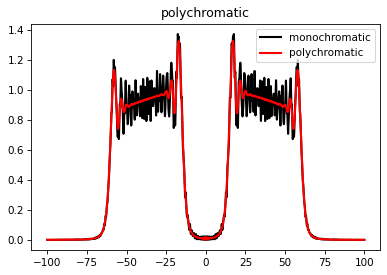

In [24]:
intensity = np.zeros_like(I_wavelengths[0].x)
for i in range(len(wavelengths)):
    intensity = intensity + spectrum_gauss[i] * abs(
        I_wavelengths[i].u)**2

plt.figure()
plt.plot(x0, abs(I0.u)**2, 'k', lw=2, label='monochromatic')
plt.plot(x0, intensity, 'r', lw=2, label='polychromatic')
plt.title('polychromatic')
plt.legend();

### Several independent experiments

In [25]:
def __experiment_double_slit_array__(slit_size):
    x0 = np.linspace(-75 * um, 75 * um, 1024 * 32)
    wavelength = 0.6328 * um
    separation = 50 * um
    z = 100 * um

    t1 = Scalar_mask_X(x0, wavelength)
    t1.slit(x0=0, size=20 * um)
    t1.double_slit(x0=0, size=slit_size, separation=separation)

    f1 = Scalar_source_X(x0, wavelength)
    f1.gauss_beam(x0=0 * um, w0=200 * um, z0=0 * um, A=1, theta=0. * degrees)

    u1 = f1 * t1
    u1.RS(z, new_field=False, verbose=False)

    return u1

In [26]:
slit_sizes = np.linspace(5 * um, 50 * um, 20)
num_processors = num_max_processors

u_s, time_proc = execute_multiprocessing(
    __experiment_double_slit_array__,
    slit_sizes,
    1,
    verbose=True)

num_proc: 1, time=1.979572057723999


In [27]:
slit_sizes = np.linspace(5 * um, 50 * um, 20)
num_processors = num_max_processors

u_s, time_proc = execute_multiprocessing(
    __experiment_double_slit_array__,
    slit_sizes,
    num_max_processors,
    verbose=True)

num_proc: 8, time=0.8904845714569092


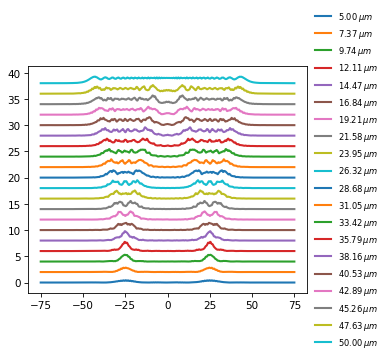

In [28]:
plt.figure()
ax = plt.subplot(111)
for i, slit_size in enumerate(slit_sizes):
    ax.plot(
        u_s[i].x,
        abs(u_s[i].u)**2 + 2 * i,
        lw=2,
        label=r"${:2.2f}\,\mu m$".format(slit_size))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(
    fontsize=8,
    frameon=False,
    loc='center left',
    bbox_to_anchor=(1, 0.5));

### def test_extended_polychromatic_source(self):

In [29]:
x0s = np.linspace(-50 * um, 50 * um, 21)
wavelengths = np.linspace(.55 * um, .65 * um, 11)
w_central = wavelengths.mean()
spectrum_gauss = gauss_spectrum(
    wavelengths=wavelengths,
    w_central=w_central,
    Dw=0.01,
    normalize=True)


In [30]:
def __experiment_extended_polychromatic_source__(dict_params):
    wavelength = dict_params['wavelength']
    x0 = dict_params['x0']

    x = np.linspace(-1250 * um, 1250 * um, 1024 * 8)
    periodo = 100 * um
    z = 5 * periodo**2 / (0.6 * um)
    z0 = -50 * mm

    t1 = Scalar_mask_X(x, wavelength)
    t1.ronchi_grating(x0=0 * um, period=periodo, fill_factor=0.5)

    f1 = Scalar_source_X(x, wavelength)
    f1.spherical_wave(
        A=1, x0=x0, z0=z0, radius=10000 * um, mask=False, normalize=True)

    u1 = f1 * t1
    u1.RS(z, new_field=False, verbose=False)

    return u1

In [31]:
u0 = __experiment_extended_polychromatic_source__(
    dict(x0=0, wavelength=w_central))

intensity, u_s, time_proc = extended_polychromatic_source(
    __experiment_extended_polychromatic_source__,
    x0s,
    wavelengths,
    spectrum_gauss,
    num_processors=num_max_processors,
    verbose=True)

num_proc: 8, time=1.0622079372406006


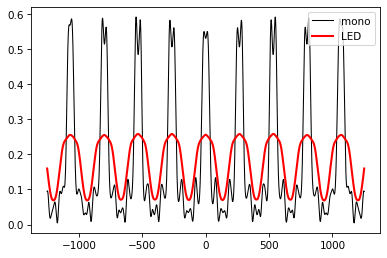

In [32]:
plt.figure()
plt.plot(u_s[0].x, abs(u0.u)**2, 'k', lw=1, label='mono')
plt.plot(u_s[0].x, intensity, 'r', lw=2, label='LED')
plt.legend();

### Multiprocessing implemented in XZ module

In [33]:
x = np.linspace(-350*um, 350*um, 1024*8)
z = np.linspace(1*mm, 10*mm, 1024)
wavelength = 0.6238 * um
period=40 * um
z_talbot=2*period**2/wavelength

In [34]:
u0=Scalar_source_X(x,wavelength)
u0.plane_wave(A=1)

t=Scalar_mask_X(x,wavelength)
t.ronchi_grating(x0=0 * um, period=40*um,  fill_factor=0.5)

talbot_effect = Scalar_field_XZ(x, z, wavelength)
talbot_effect.incident_field(u0*t)

In [35]:
t0=time.time()
talbot_effect.RS(num_processors=1)
t1=time.time()
t_proc1=t1-t0
print(t_proc1, t_proc1/len(z))

12.085466146469116 0.011802213033661246


In [36]:
t0=time.time()
talbot_effect.RS(num_processors=num_max_processors-2)
t1=time.time()
t_procn=t1-t0

print(t_procn, t_procn/len(z))

30.363226175308228 0.02965158806182444


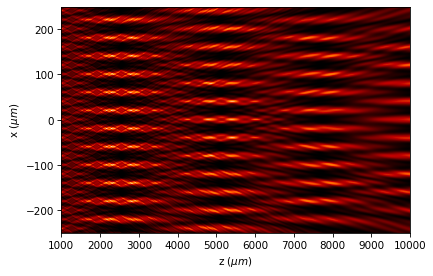

In [37]:
talbot_effect.draw()
plt.ylim(-250*um, 250*um);